<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/Self_Sup/MoCov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moco Pytorch Toturial

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
from PIL import Image
import os
import time
from collections import OrderedDict
import copy
import random
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Dataset
- use STL-10 dataset provided by torchvision package 

In [2]:
# define transformation for query and key

# transformation for train
train_transform = transforms.Compose([
                transforms.Resize((250,250)),
                transforms.RandomResizedCrop(224),
                transforms.RandomApply([
                        transforms.ColorJitter(0.5, 0.5, 0.5)
                        ], p=0.8),
                transforms.RandomGrayscale(p=0.2),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


# define class to make query and key
class Split:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

In [3]:
# specify data path
path2data = './data'
os.makedirs(path2data, exist_ok=True)

# load STL-10 dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=Split(train_transform))

Files already downloaded and verified


img size:  torch.Size([3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

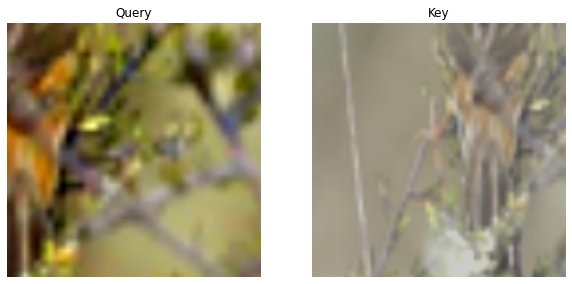

In [4]:
# check sample image
img, label = train_ds[0]

query, key = img[0], img[1]
print('img size: ',query.shape)

# display query and key
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*query+0.5))
plt.title('Query')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*key+0.5))
plt.title('Key')
plt.axis('off')

In [5]:
# define dataloader
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

# define encoders for query and key

In [6]:
# I use q encoder as resnett18 model
q_encoder = resnet18(pretrained=False)

# define classifier for our task
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(q_encoder.fc.in_features, 100)),
    ('added_relu1', nn.ReLU()),
    ('fc2', nn.Linear(100, 50)),
    ('added_relu2', nn.ReLU()),
    ('fc3', nn.Linear(50, 25))
]))

# replace classifier 
# and this classifier make representation have 25 dimention 
q_encoder.fc = classifier

# define encoder for key by coping q_encoder
k_encoder = copy.deepcopy(q_encoder)

# move encoders to device
q_encoder = q_encoder.to(device)
k_encoder = k_encoder.to(device)

In [7]:
# check model
summary(q_encoder, (3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training

In [8]:
# define loss function
def loss_func(q,k,queue,t=0.05):
    # t: temperature

    N = q.shape[0] # batch_size
    C = q.shape[1] # channel

    # bmm: batch matrix multiplication
    pos = torch.exp(torch.div(torch.bmm(q.view(N,1,C), k.view(N,C,1)).view(N,1),t))
    neg = torch.sum(torch.exp(torch.div(torch.mm(q.view(N,C),torch.t(queue)),t)),dim=1)

    # denominator is sum over pos and neg
    denominator = pos + neg

    return torch.mean(-torch.log(torch.div(pos,denominator)))

In [9]:
# define optimizer
opt = optim.Adam(q_encoder.parameters())

In [10]:
# initialize the queue
queue = None
K = 8192 # K: number of negatives to store in queue

# fill the queue with negative samples
flag = 0
if queue is None:
    while True:

        with torch.no_grad():
            for img, _ in train_dl:
                # extract key samples
                xk = img[1].to(device)
                k = k_encoder(xk).detach()

                if queue is None:
                    queue = k
                else:
                    if queue.shape[0] < K: # queue < 8192
                        queue = torch.cat((queue,k),0)
                    else:
                        flag = 1 # stop filling the queue

                if flag == 1:
                    break 

        if flag == 1:
            break

queue = queue[:K]

In [11]:
# check queue
print('number of negative samples in queue : ',len(queue))

number of negative samples in queue :  8192


In [12]:
# define function to training
def Training(q_encoder, k_encoder, num_epochs, queue=queue, loss_func=loss_func, opt=opt, data_dl=train_dl, sanity_check=False):
    loss_history = []
    momentum = 0.999
    start_time = time.time()
    path2weights = './models/q_weights.pt'
    len_data = len(data_dl.dataset)

    q_encoder.train()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))

        q_encoder.train()
        running_loss = 0
        for img, _ in data_dl:
            # retrieve query and key
            xq = img[0].to(device)
            xk = img[1].to(device)

            # get model outputs
            q = q_encoder(xq)
            k = k_encoder(xk).detach()

            # normalize representations
            q = torch.div(q, torch.norm(q,dim=1).reshape(-1,1))
            k = torch.div(k, torch.norm(k,dim=1).reshape(-1,1))

            # get loss value
            loss = loss_func(q, k, queue)
            running_loss += loss

            opt.zero_grad()
            loss.backward()
            opt.step()

            # update the queue
            queue = torch.cat((queue, k), 0)

            if queue.shape[0] > K:
                queue = queue[256:,:]
            
            # update k_encoder
            for q_params, k_params in zip(q_encoder.parameters(), k_encoder.parameters()):
                k_params.data.copy_(momentum*k_params + q_params*(1.0-momentum))

        # store loss history
        epoch_loss = running_loss / len(data_dl.dataset)
        loss_history.append(epoch_loss)

        print('train loss: %.6f, time: %.4f min' %(epoch_loss,(time.time()-start_time)/60))

        if sanity_check:
            break

    # save weights
    # torch.save(q_encoder.state_dict(), path2weights);

    return q_encoder, k_encoder, loss_history

In [13]:
# create folder to save q_encoder model weights
os.makedirs('./models', exist_ok=True)

# start training
num_epochs = 300
q_encoder, _, loss_history = Training(q_encoder, k_encoder, num_epochs=num_epochs, sanity_check=False)

Epoch 0/299
train loss: 0.032916, time: 0.9502 min
Epoch 1/299
train loss: 0.033337, time: 1.8988 min
Epoch 2/299
train loss: 0.032140, time: 2.8543 min
Epoch 3/299
train loss: 0.032203, time: 3.7964 min
Epoch 4/299
train loss: 0.032254, time: 4.7424 min
Epoch 5/299
train loss: 0.032417, time: 5.6738 min
Epoch 6/299
train loss: 0.032692, time: 6.5925 min
Epoch 7/299
train loss: 0.032840, time: 7.5148 min
Epoch 8/299
train loss: 0.033016, time: 8.4470 min
Epoch 9/299
train loss: 0.033145, time: 9.3661 min
Epoch 10/299
train loss: 0.033079, time: 10.2808 min
Epoch 11/299
train loss: 0.033208, time: 11.2101 min
Epoch 12/299
train loss: 0.033166, time: 12.1358 min
Epoch 13/299
train loss: 0.032632, time: 13.0733 min
Epoch 14/299
train loss: 0.032799, time: 14.0190 min
Epoch 15/299
train loss: 0.032809, time: 14.9506 min
Epoch 16/299
train loss: 0.032730, time: 15.8864 min
Epoch 17/299
train loss: 0.032621, time: 16.8183 min
Epoch 18/299
train loss: 0.032356, time: 17.7514 min
Epoch 19/299


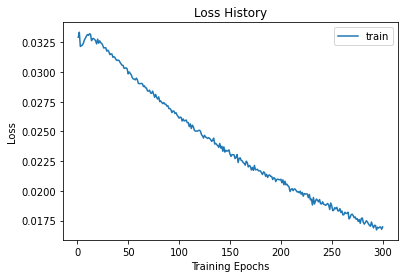

In [14]:
# plot loss history
plt.title('Loss History')
plt.plot(range(1, num_epochs+1), loss_history, label='train')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# Transfer Learning
- Make transfer dataset have 10% of STL-dataset

In [15]:
# define transformation
data_transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [16]:
# load STL-10 dataset
train_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transform)
val_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transform)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
# count the number of images per classes in train_ds
import collections

y_train = [y for _, y in train_ds]
counter_train = collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [18]:
# split the indices of train_ds into two grous
# StratifiedShuffleSplit split the data in same proportion of labels
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

indices = list(range(len(train_ds)))

for _, transfer_index in sss.split(indices, y_train):
    print('transfer_index:', transfer_index[:10])
    print(len(transfer_index))

transfer_index: [4234 1573 1816 3332  504   81 2397 4430 3512 4569]
500


In [19]:
# create datasets from train_ds
from torch.utils.data import Subset

transfer_ds = Subset(train_ds, transfer_index)

In [20]:
# check transfer_ds

y_transfer = [y for _, y in transfer_ds]

counter_transfer = collections.Counter(y_transfer)
print(counter_transfer)

Counter({9: 50, 3: 50, 4: 50, 0: 50, 2: 50, 8: 50, 1: 50, 7: 50, 5: 50, 6: 50})


In [21]:
# define dataloader
# transfer_ds has 500 images
transfer_dl = DataLoader(transfer_ds, 32, True)
val_dl = DataLoader(val_ds, 64, True)

### removing the projection head of q_encoder

### define LinearNet for transfer learning

In [22]:
# removing the projection head of q_encoder
if len(nn.Sequential(*list(q_encoder.fc.children()))) == 5:
    q_encoder.fc = nn.Sequential(*list(q_encoder.fc.children())[:-3])

In [23]:
print(*list(q_encoder.fc))

Linear(in_features=512, out_features=100, bias=True) ReLU()


In [24]:
# define Linear Classifier for transfer learning
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(100,10)

    def forward(self, x):
        x = self.fc1(x)
        return x

linear_classifier = LinearClassifier().to(device)

### training LinearClassifier using transfer dataset

In [25]:
# training LinearClassifier
linear_epoch = 20
linear_loss_func = nn.CrossEntropyLoss()
linear_opt = optim.SGD(linear_classifier.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)

In [26]:
loss_hist = {'train':[], 'val':[]}
start_time = time.time()

# start training
for epoch in range(linear_epoch):
    print('Epoch {}/{}'.format(epoch, linear_epoch-1))

    running_train_loss = 0
    running_val_loss = 0
    running_metric = 0

    # transfer dataloader
    linear_classifier.train()
    for x, y in transfer_dl:
        x = x.to(device)
        y = y.to(device)

        # extract features using q_encoder
        with torch.no_grad():
            output_encoder = q_encoder(x)
        
        linear_opt.zero_grad()
        pred = linear_classifier(output_encoder)
        loss = linear_loss_func(pred, y)
        running_train_loss += loss
        loss.backward()
        linear_opt.step()

    train_loss = running_train_loss / len(transfer_dl.dataset)
    loss_hist['train'].append(train_loss)

    # validation dataloader
    linear_classifier.eval()
    for x, y in val_dl:
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            output_encoder = q_encoder(x)
            pred = linear_classifier(output_encoder)
            loss = linear_loss_func(pred, y)
            running_val_loss += loss
            pred = pred.argmax(1, keepdim=True)
            metric = pred.eq(y.view_as(pred)).sum().item()

        running_val_loss += loss    
        running_metric += metric

    val_loss = running_val_loss / len(val_dl.dataset)
    loss_hist['val'].append(val_loss)
    val_metric = running_metric / len(val_dl.dataset) 
    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/19
train loss: 0.905640, val loss: 0.577060, accuracy: 30.98, time: 0.2138 min
----------
Epoch 1/19
train loss: 0.707337, val loss: 0.592269, accuracy: 36.74, time: 0.4278 min
----------
Epoch 2/19
train loss: 0.620452, val loss: 0.489295, accuracy: 37.58, time: 0.6450 min
----------
Epoch 3/19
train loss: 0.493108, val loss: 0.681153, accuracy: 28.44, time: 0.8611 min
----------
Epoch 4/19
train loss: 0.511705, val loss: 0.688560, accuracy: 34.10, time: 1.0753 min
----------
Epoch 5/19
train loss: 0.510753, val loss: 0.499642, accuracy: 34.24, time: 1.2892 min
----------
Epoch 6/19
train loss: 0.461902, val loss: 0.327663, accuracy: 42.92, time: 1.5043 min
----------
Epoch 7/19
train loss: 0.437970, val loss: 0.425673, accuracy: 33.48, time: 1.7204 min
----------
Epoch 8/19
train loss: 0.454615, val loss: 0.665194, accuracy: 30.84, time: 1.9383 min
----------
Epoch 9/19
train loss: 0.467067, val loss: 0.550077, accuracy: 37.06, time: 2.1525 min
----------
Epoch 10/19
train lo

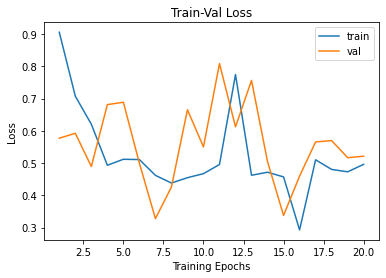

In [27]:
num_epochs = linear_epoch

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# t-SNE visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


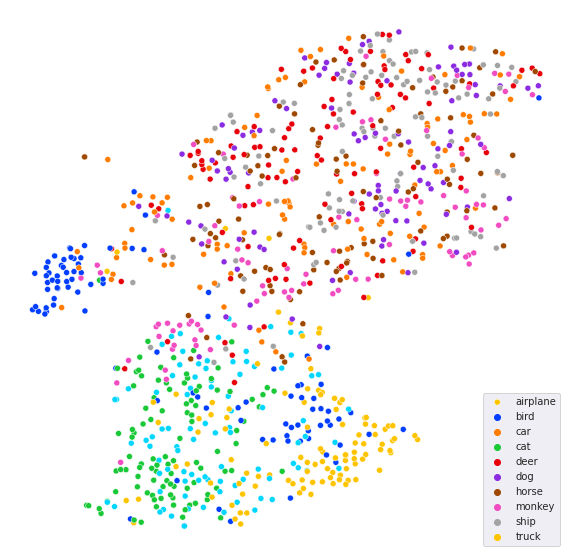

In [28]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

def plot_vecs_n_labels(v, labels, fname):
    fig = plt.figure(figsize = (10,10))
    plt.axis('off')
    sns.set_style('darkgrid')
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 10))
    plt.legend(['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'])
    plt.savefig(fname)


# change batch_size
val_dl = DataLoader(val_ds, 1024, True)

for x, y in val_dl:
    x = x.to(device)
    with torch.no_grad():
        pred = q_encoder(x)
        pred = linear_classifier(pred)
    pred_tsne = tsne.fit_transform(pred.cpu().data)
    plot_vecs_n_labels(pred_tsne, y, 'tsen.png')
    break